# Implementación articulo 3D fruit rotation

En este notebook se tiene la implementación tentativa hasta el momento para implementar los puntos del paper 3D fruit rotation.

In [2]:
import cv2
import os
import notebook_functions
import matplotlib.pyplot as plt
from statistics import mean
from IPython.display import Image

Se declaran 3 folders - 1 por tipo de fruta (sphere, oblate, prolate)
Se define una lista con estos paths y otra que se usara para definir en que parte del diccionario se guardarán los resultados.

In [3]:
sphere_path = "./data/oranges/obj0001"
oblate_path = "./data/tomatoes/obj0001"
oblate_path_2 = "./data/mandarins/obj0006"

fruits_types = [sphere_path, oblate_path, oblate_path_2]
fruit_types_by_index = ["orange", "tomato", "mandarin"]

### Diccionario de resultados finales
Este diccionario guarda los resultados hasta el punto 3.1.2 del paper
Se tienen llaves extra para probar las diferentes formulas en los tres tipos de frutas y hacer analisis.

In [4]:
results_dict = {
    "orange": {
        "semi_axes_a_all": [],
        "semi_axes_b_all": [],
        "projected_ellipses": [],
        "oblate_angles": [],
        "angle_images": [],
        "principal_axes": {
            "sphere": (0, 0),
            "oblate": (0, 0),
            "prolate": (0, 0)
        }
    },
    "tomato": {
        "semi_axes_a_all": [],
        "semi_axes_b_all": [],
        "projected_ellipses": [],
        "oblate_angles": [],
        "angle_images": [],
        "principal_axes": {
            "sphere": (0, 0),
            "oblate": (0, 0),
            "prolate": (0, 0)
        }
    },
    "mandarin": {
        "semi_axes_a_all": [],  # Major axes
        "semi_axes_b_all": [],  # Minor axes
        "projected_ellipses": [],
        "oblate_angles": [],  # Calculated angles for each view
        "angle_images": [],
        "principal_axes": {
            "sphere": (0, 0), # (A, B)
            "oblate": (0, 0), # (A, B)
            "prolate": (0, 0) # (A, B)
        }
    }
}

# Punto 3.1.1 en tipos de frutas
El punto 3.1.3 es para conseguir los semi-ejes "a" y "b" de una vista.
A continuación se muestra un ciclo para conseguir los semi-ejes a y b de todas las vistas de cada tipo de fruta y guardarlos en el diccionario anterior.

__Primer ciclo__
``` for index, fruit_type in enumerate(fruits_types): ```
En este for se ciclan los nombres de los folders con su index.
El indice se ocupa para definir el tipo de fruta actual y guardar los resultados en el diccioanrio correcto
Se crea una lista de todos los nombres de los archivos dentro de folder actual *fruit_type*

__Segundo ciclo__
``` for image_name in image_files: ```
Este ciclo ira por cada vista dentro del folder del tipo de fruta actual y conseguirá los ejes a y b
- Se genera una mascara de la vista actual
- Se calcula la elipse de esa mascara
- Se consigue los ejes (Refers to the full length of the longer and shorter axis of an ellipse)
- Se consiguen los semi-ejes que son la mitad del "full length axe"
- Se guardan los resultados de a y b en el diccionario de resultados


In [5]:
for index, fruit_type in enumerate(fruits_types): # Test with all fruit types
    current_fruit_type_name = fruit_types_by_index[index]
    image_files = sorted(file for file in os.listdir(fruit_type))

    for image_name in image_files:
        file_path = os.path.join(fruit_type, image_name)
        img = cv2.imread(file_path)
        mask = notebook_functions.create_mask_from_img(img)
        ellipse = notebook_functions.calculate_ellipse_from_mask(mask)
        axes_length, _, _, _ = ellipse
        major_axis, minor_axis = axes_length

        results_dict[current_fruit_type_name]["semi_axes_a_all"].append(major_axis)
        results_dict[current_fruit_type_name]["semi_axes_b_all"].append(minor_axis)

print("LEN B AXES TOMATO", len(results_dict["tomato"]["semi_axes_b_all"]))
print("LEN B AXES MANDARIN", len(results_dict["mandarin"]["semi_axes_b_all"]))

LEN B AXES TOMATO 17
LEN B AXES MANDARIN 15


# Punto 3.1.2
Este punto del paper genera la esferoide aproximada usando los ejes de todas las vistas que se consiguen en el punto 3.1.1.
Para cada tipo de fruta (prolate, oblate, sphere) se consigue las 3 esferoides usando cada formula y se guardan el tipo de esferoide aproximada dependiendo la formula que se uso para calcularlo.

In [6]:
for index, fruit_type in enumerate(fruit_types_by_index): # Test with all fruit types
    a_all_views = results_dict[fruit_type]["semi_axes_a_all"]
    b_all_views = results_dict[fruit_type]["semi_axes_b_all"]

    # FOR SPHERE FORMULA
    axes_sum = [(x + y) / 2 for x, y in zip(a_all_views, b_all_views)]
    sphere_axe = mean(axes_sum)
    results_dict[fruit_type]["principal_axes"]["sphere"] = (sphere_axe, sphere_axe)

    # FOR OBLATE FORMULA
    results_dict[fruit_type]["principal_axes"]["oblate"] = (mean(a_all_views), min(b_all_views))  # (A, B)

    # FOR PROLATE FORMULA
    results_dict[fruit_type]["principal_axes"]["prolate"] = (max(a_all_views), mean(b_all_views))  # (A, B)

### Test to check spheroid size of fruit img
sphere - oranges
oblate - tomatoes
prolate - mandarins

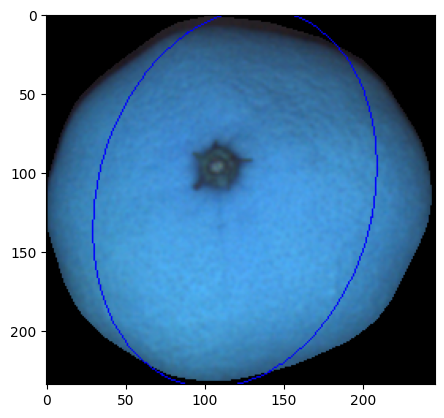

In [7]:
img_path = "./data/mandarins/obj0006/im00.png"
spheroid_semi_axes = results_dict["mandarin"]["principal_axes"]["oblate"]

resulting_img = notebook_functions.draw_spheroid_on_view(img_path, spheroid_semi_axes)
plt.imshow(resulting_img)

In [10]:
views_w_spehroids = [[], [], []]  # [oranges], [tomatoes], [mandarins]

# Store all the views for that type of fruit with the spheroid drawn on top
for index, fruit_type in enumerate(fruits_types):
    current_fruit_type_name = fruit_types_by_index[index]
    image_files = [file for file in os.listdir(fruit_type)]
    colors = [(0, 255, 0), (255, 0, 0), (255, 255, 0)]

    for image_name in image_files:
        file_path = os.path.join(fruit_type, image_name)
        img = cv2.imread(file_path)
        # spheroid_semi_axes_sphere = results_dict[current_fruit_type_name]["principal_axes"]["sphere"]
        spheroid_semi_axes_oblate = results_dict[current_fruit_type_name]["principal_axes"]["oblate"]
        # spheroid_semi_axes_prolate = results_dict[current_fruit_type_name]["principal_axes"]["prolate"]

        # notebook_functions.draw_spheroid_on_view(file_path, spheroid_semi_axes_sphere, colors[0], img)
        notebook_functions.draw_spheroid_on_view(file_path, spheroid_semi_axes_oblate, colors[1], img)
        # resulting_img = notebook_functions.draw_spheroid_on_view(file_path, spheroid_semi_axes_prolate, colors[2], img)
        views_w_spehroids[index].append(resulting_img)

# See each view with the calculated spheroids (sphere, oblate, prolate)

### Orange views (all spheroids)
Colors
- Green: Sphere
- Red: Oblate
- Yellow: Prolate

['im09.png', 'im08.png', 'im06.png', 'im12.png', 'im13.png', 'im07.png', 'im11.png', 'im05.png', 'im04.png', 'im10.png', 'im14.png', 'im00.png', 'im01.png', 'im15.png', 'im03.png', 'im02.png']


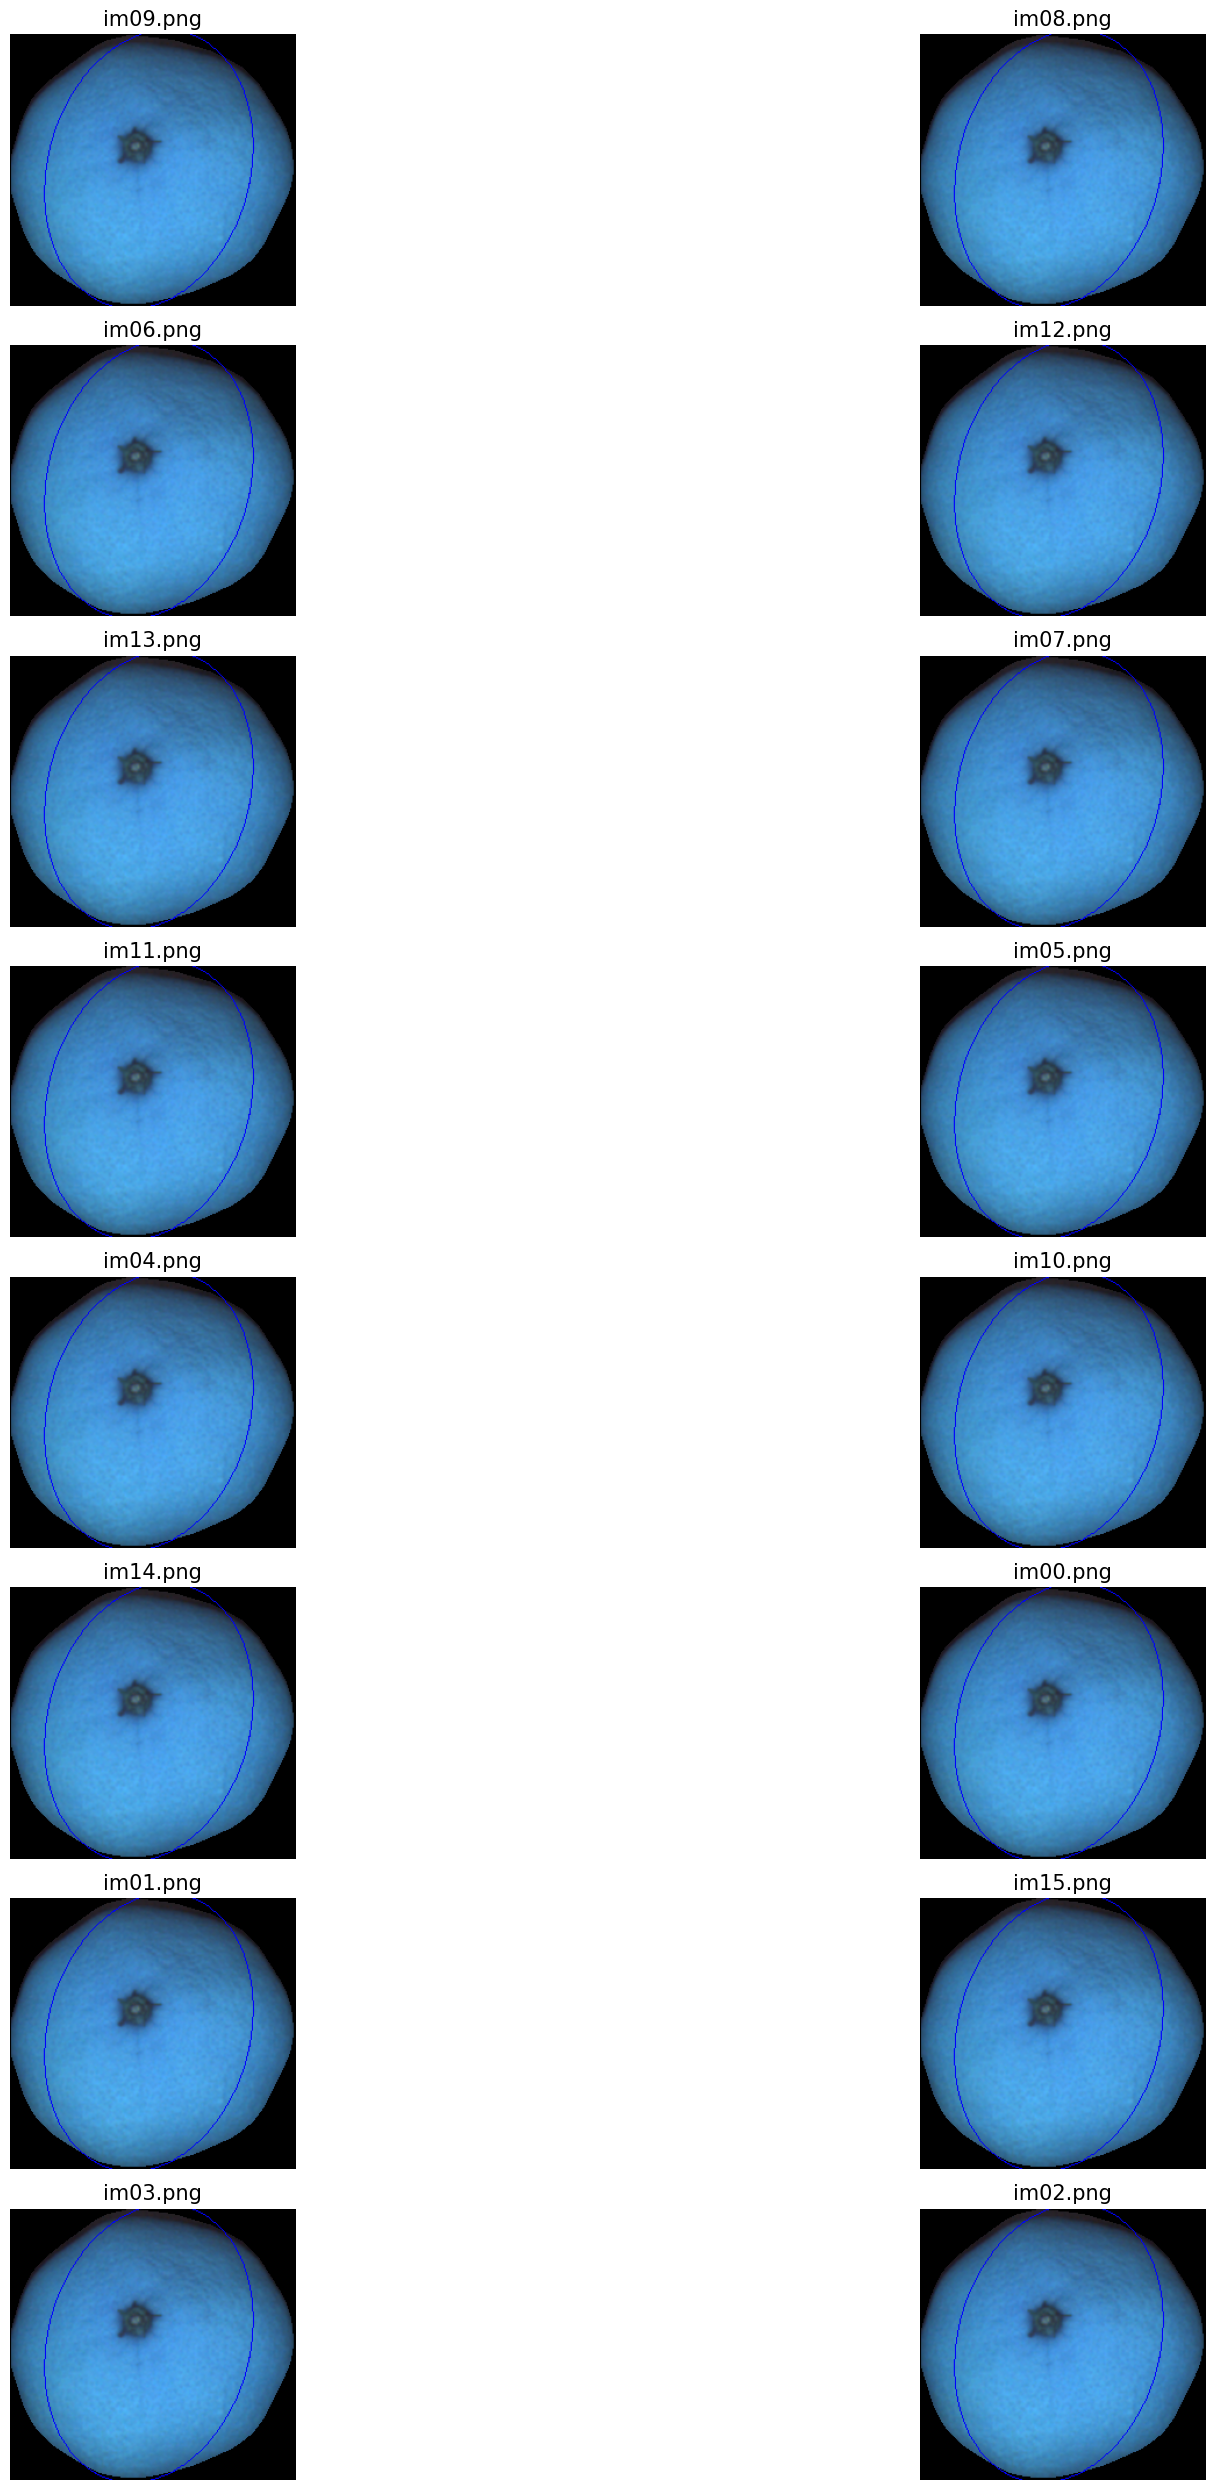

In [11]:
image_files = [file for file in os.listdir(sphere_path)]
print(image_files)
notebook_functions.table_for_views_w_spheroid(views_w_spehroids[0], image_files)

### Tomatoes views (all spheroids)
Colors
- Green: Sphere
- Red: Oblate
- Yellow: Prolate

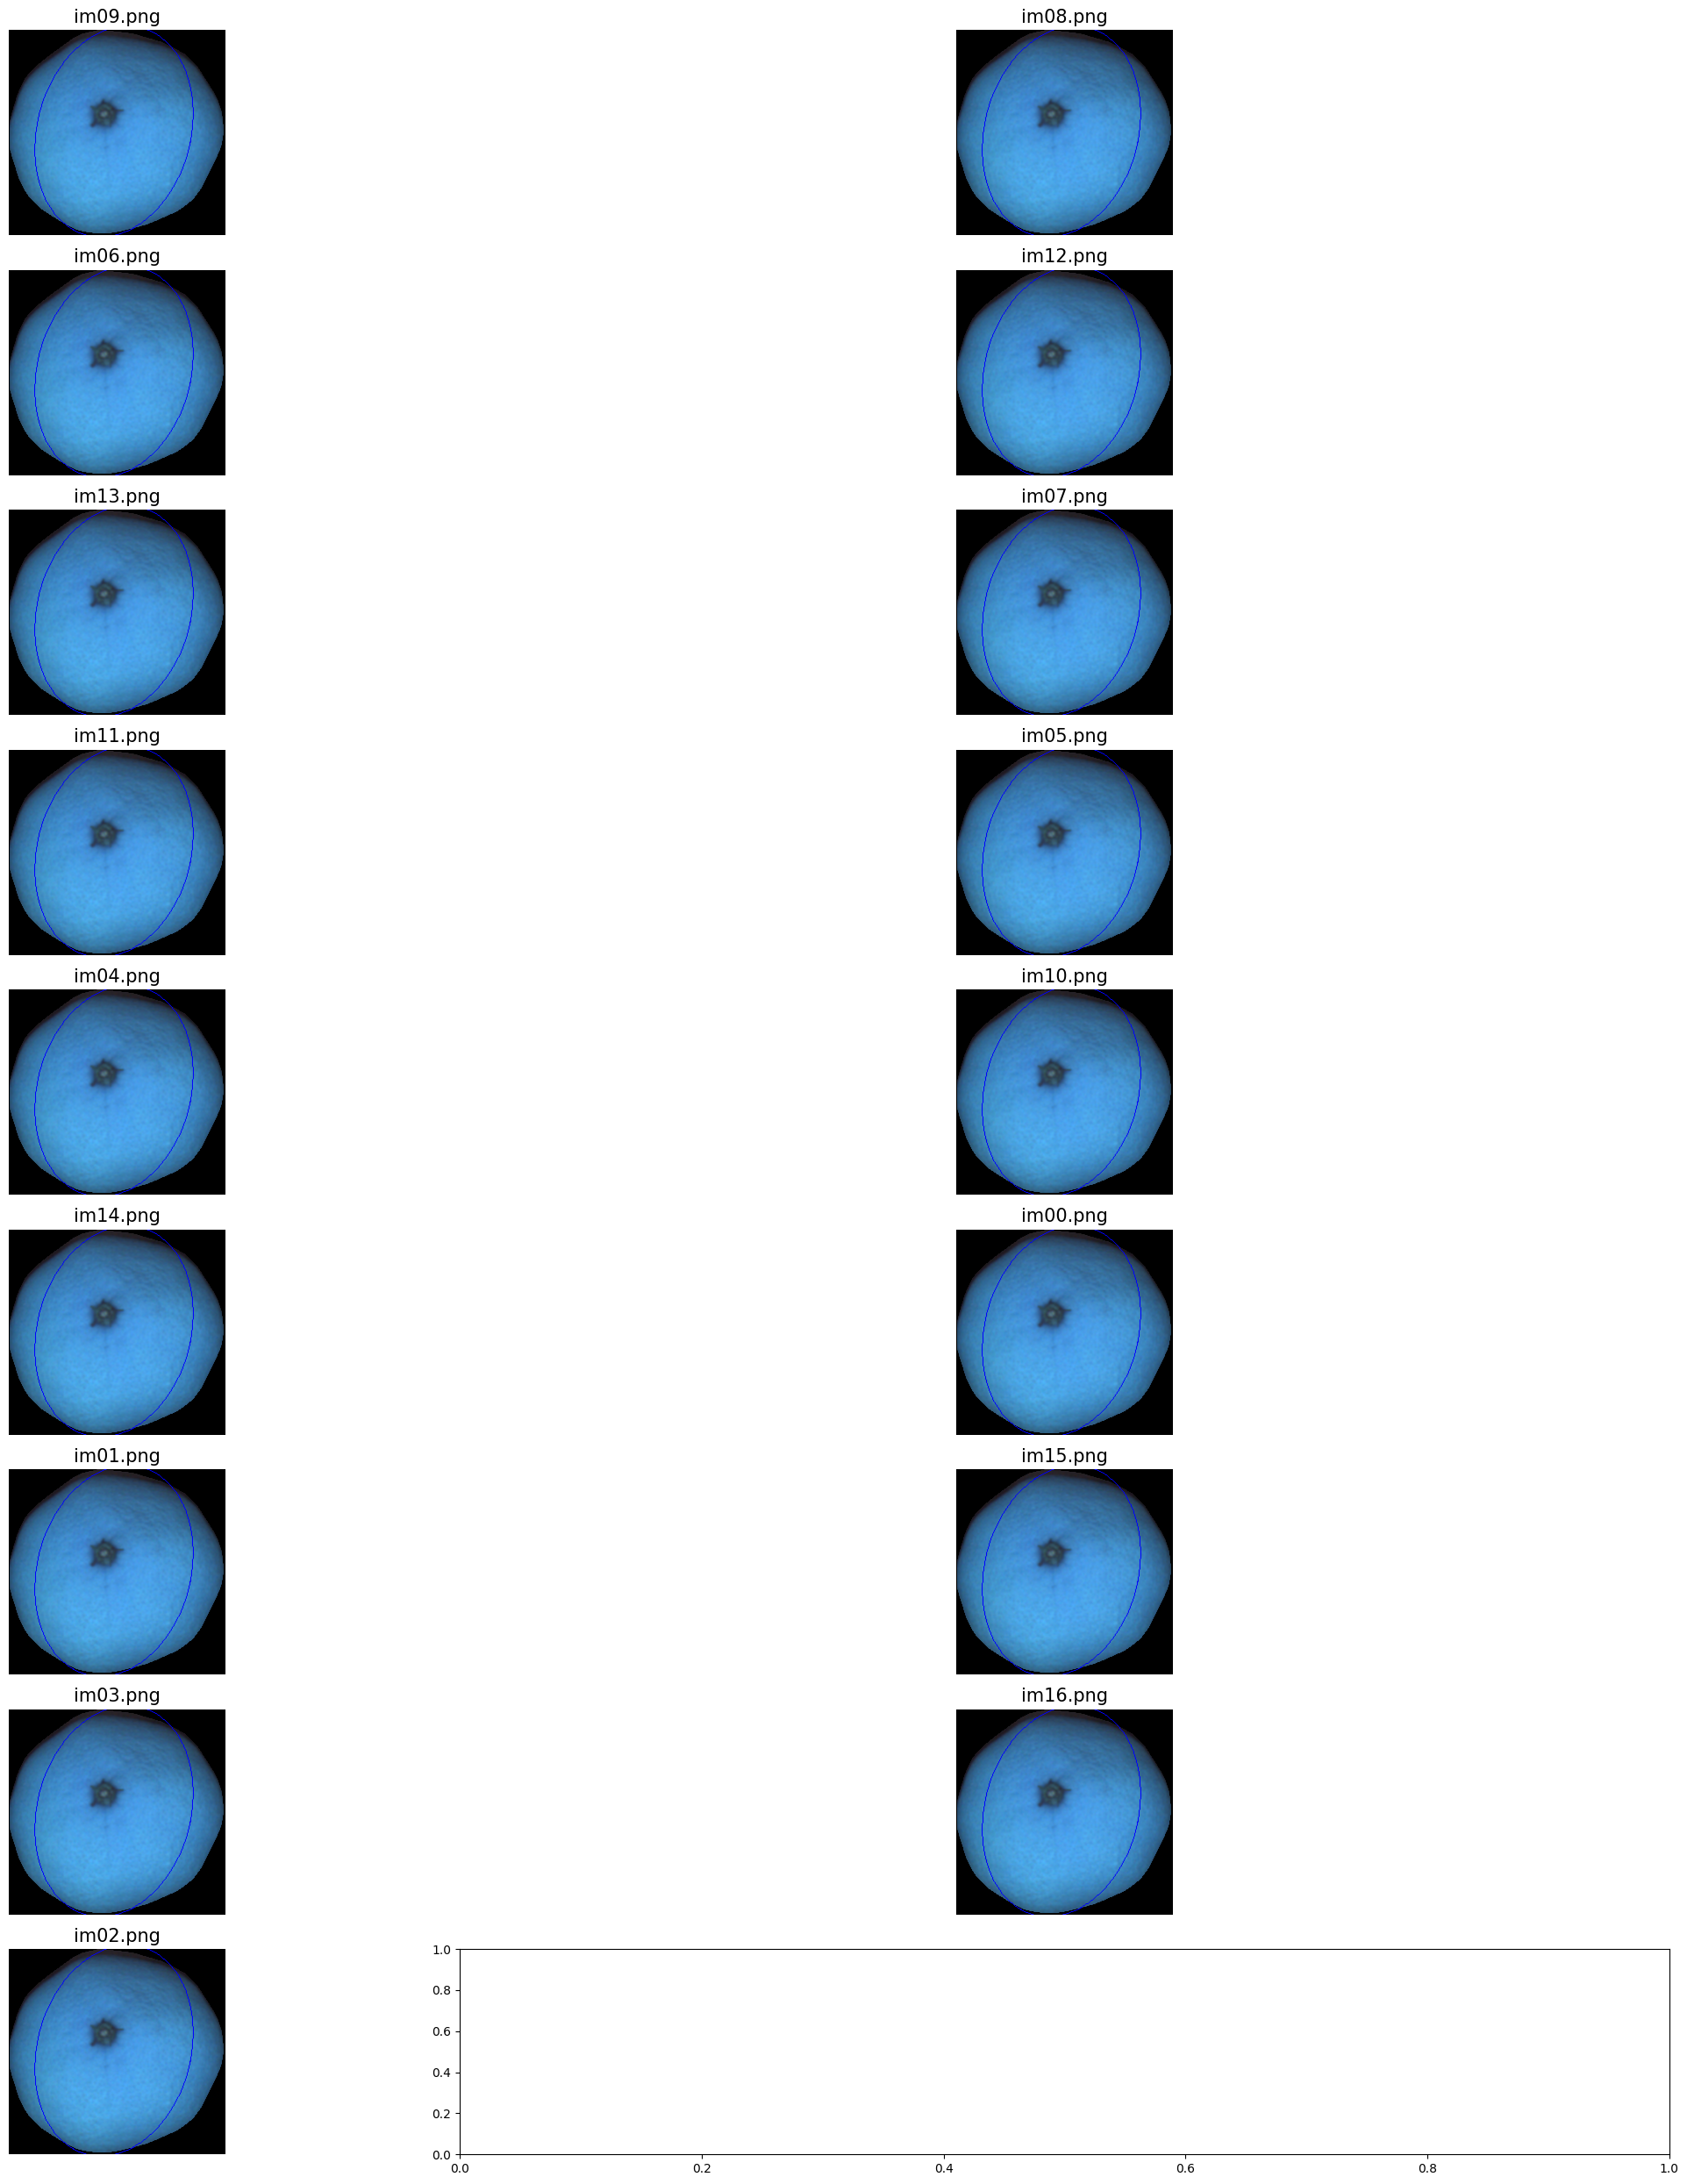

In [8]:
image_files = [file for file in os.listdir(oblate_path)]
notebook_functions.table_for_views_w_spheroid(views_w_spehroids[1], image_files)

### Mandarin views (all spheroids)
Colors
- Green: Sphere
- Red: Oblate
- Yellow: Prolate

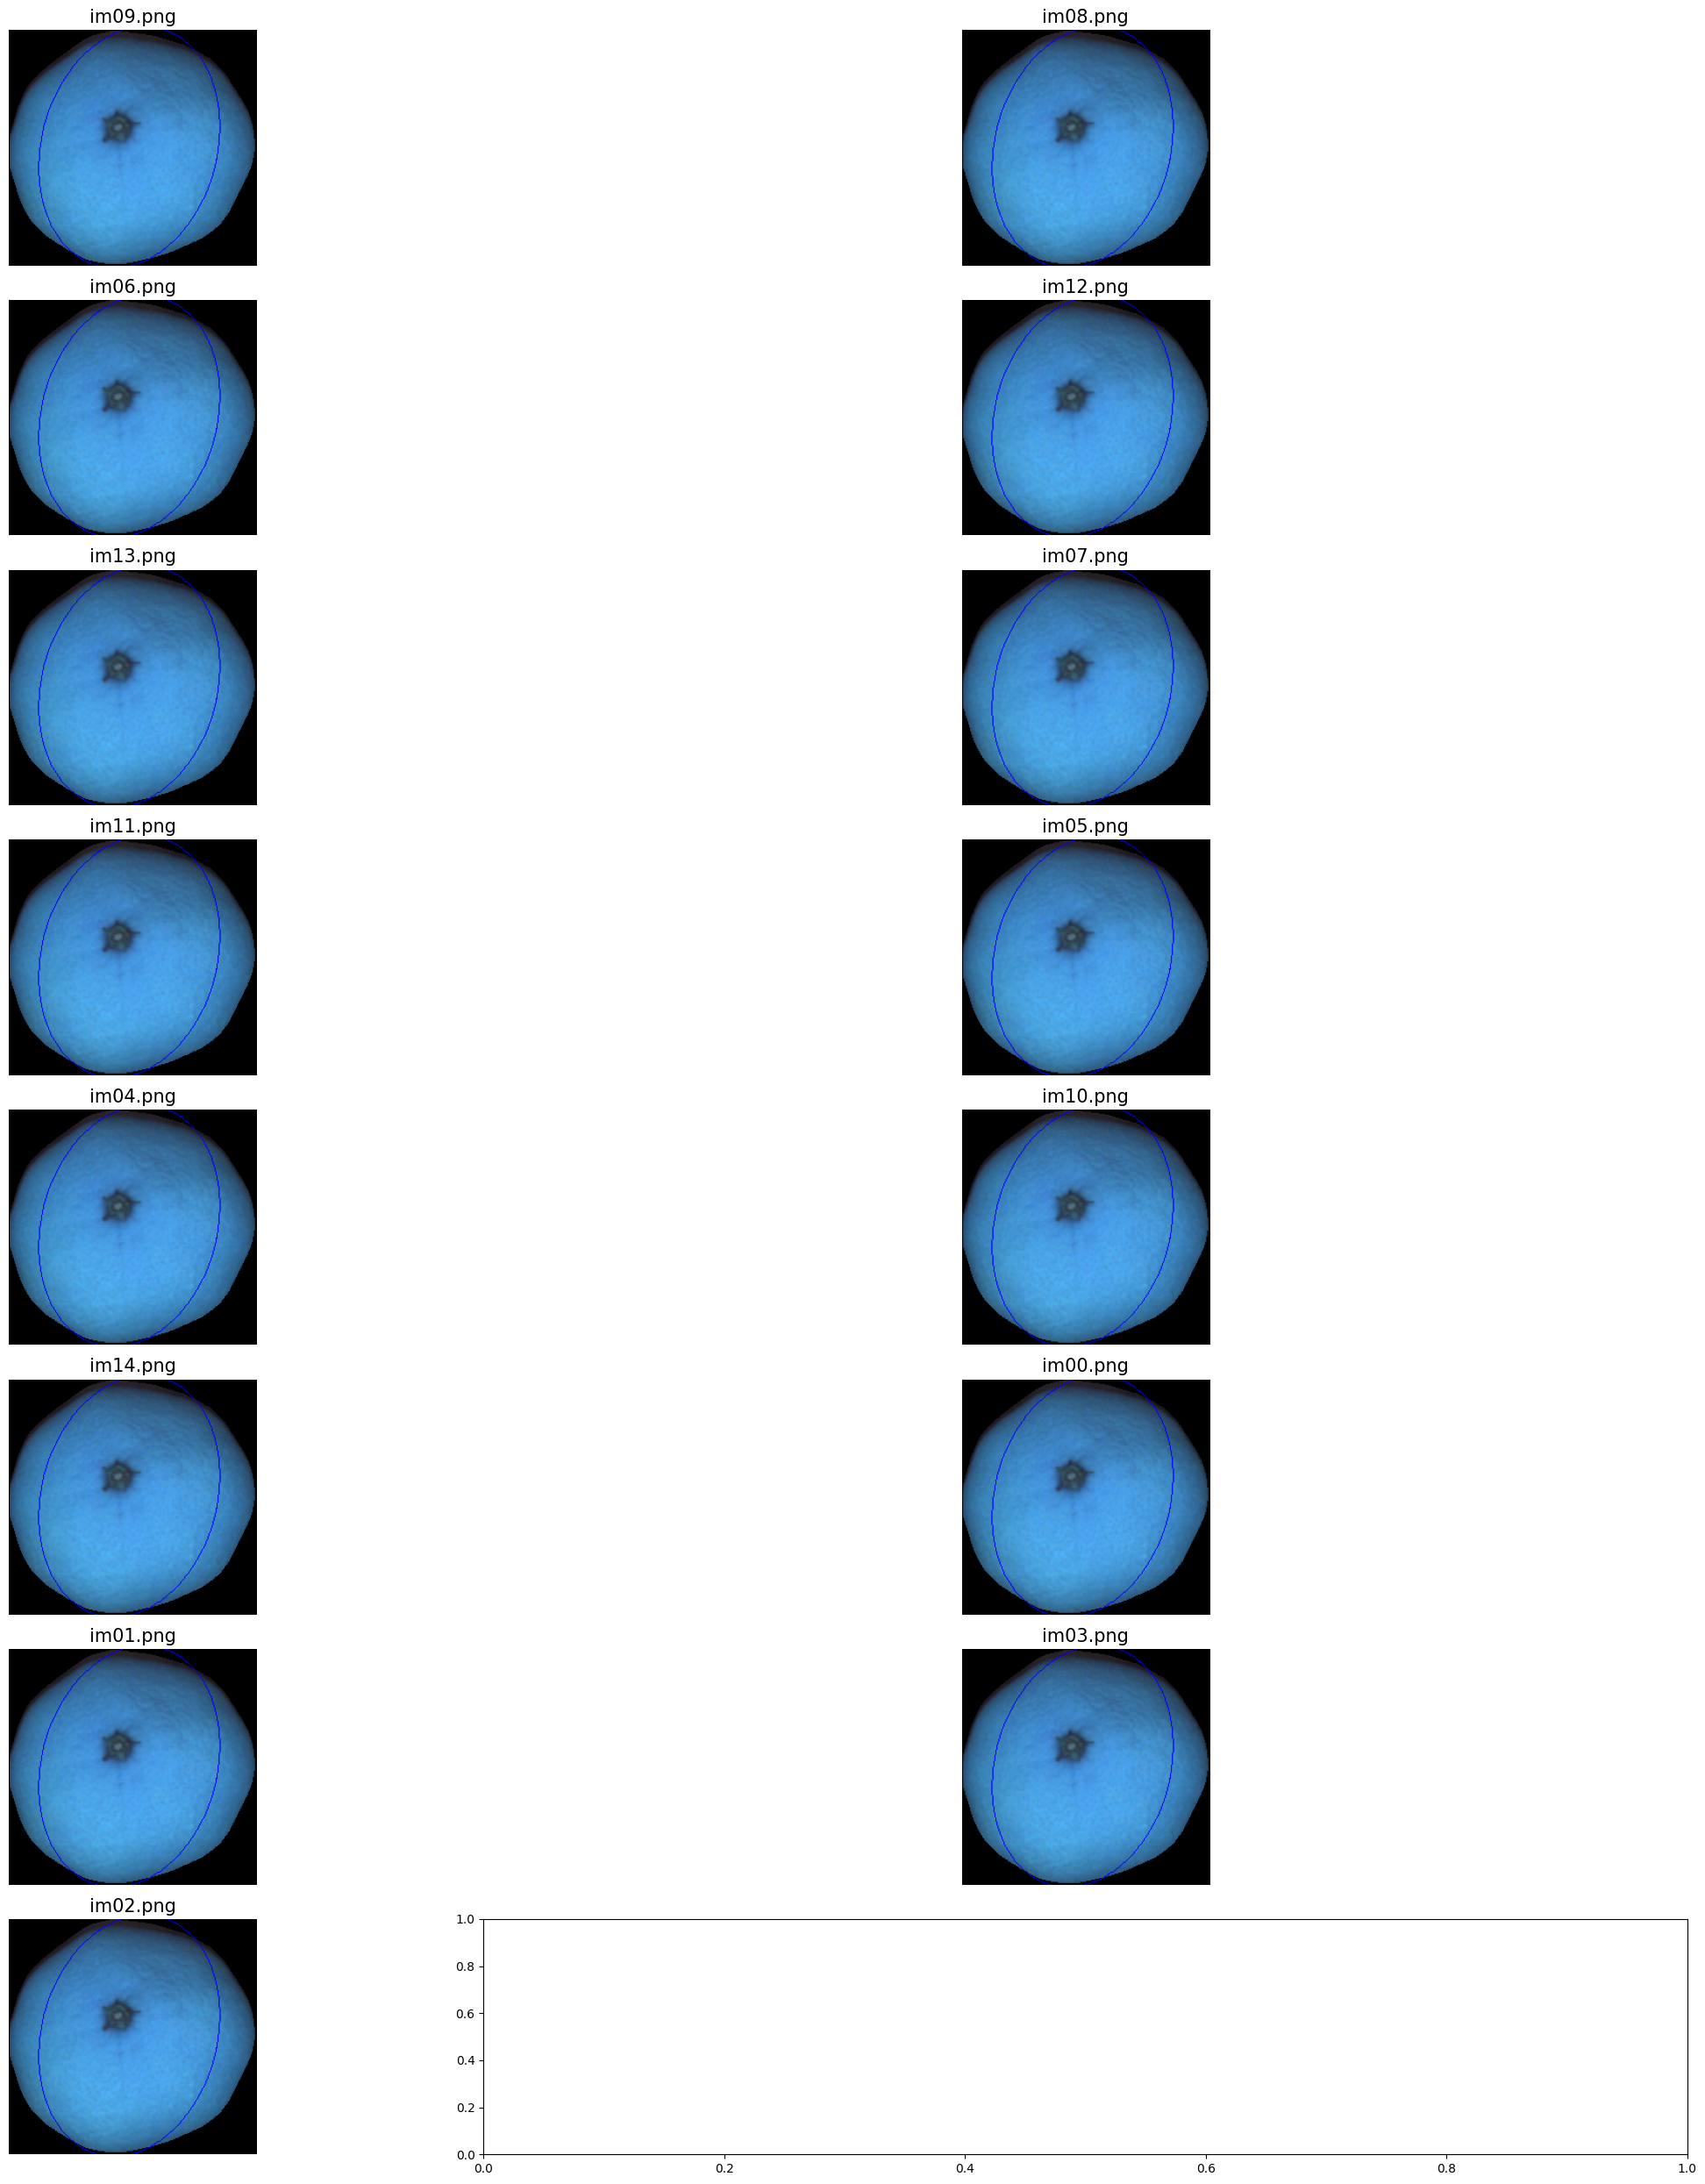

In [10]:
image_files = [file for file in os.listdir(oblate_path_2)]
notebook_functions.table_for_views_w_spheroid(views_w_spehroids[2], image_files)

# Point 3.1.3
Calculate fruit angle for each view


### Select fruit to check angles

In [11]:
oblate_fruits = fruits_types[1:]
oblate_fruits_names = fruit_types_by_index[1:]

for index, fruit_type in enumerate(oblate_fruits):
    current_fruit_type_name = oblate_fruits_names[index]
    image_files = sorted(file for file in os.listdir(fruit_type))
    oblate_angles = [-1 for element in range(len(image_files))]
    spheroid = results_dict[current_fruit_type_name]["principal_axes"]["oblate"]
    oblate_b_axes = results_dict[current_fruit_type_name]["semi_axes_b_all"]

    for index_view, image_name in enumerate(image_files):
        file_path = os.path.join(fruit_type, image_name)
        img = cv2.imread(file_path)
        img_axes = cv2.imread(file_path)

        oblate_angle = notebook_functions.angle_estimation(index_view, oblate_angles, spheroid, oblate_b_axes)
        notebook_functions.write_angle_on_img(img, oblate_angle, (0, 255, 0))
        results_dict[current_fruit_type_name]["angle_images"].append(img)

    results_dict[current_fruit_type_name]["oblate_angles"] = oblate_angles
    angle_edited_images = results_dict[current_fruit_type_name]["angle_images"]
    joined_oblate_images = notebook_functions.join_images(angle_edited_images)
    img_name = current_fruit_type_name + ".png"
    cv2.imwrite(img_name, joined_oblate_images)

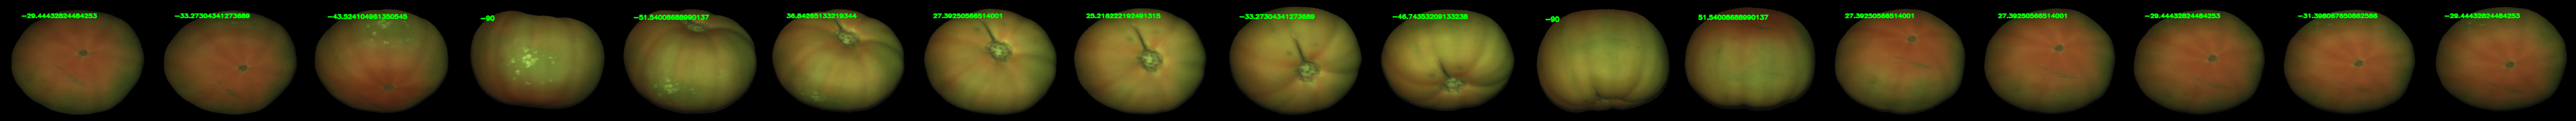

In [12]:
img_name = "tomato.png"
Image(filename=img_name, width=2000)

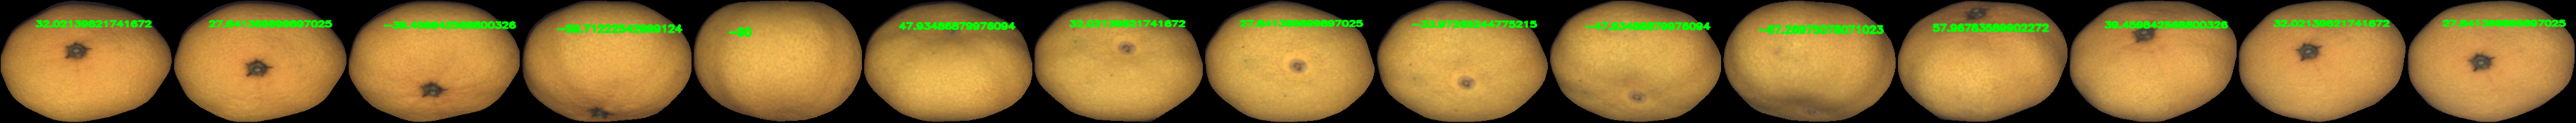

In [13]:
img_name = "mandarin.png"
Image(filename=img_name, width=2000)